In [1]:
import setup
setup.init_django()
from market import services as market_services
from market import tasks as market_tasks
from market.models import Company
import json
from decouple import config

In [2]:
ticker = "AAPL"
name = "Apple"
company, _ = Company.objects.get_or_create(name=name, ticker=ticker)
company.id

2

In [6]:
market_tasks.sync_historical_stock_data(
    years_ago=1, 
    company_ids=[company.id], 
    use_celery=False, 
    verbose=True
)

#use celery / async
#market_tasks.sync_historical_stock_data.delay(years_ago=5, company_ids=[company.id], use_celery=True, verbose=False)

Historical sync days ago 30
dataset length 3411
Doing chunk 0
finished chunk 0
Doing chunk 1000
finished chunk 1000
Doing chunk 2000
finished chunk 2000
Doing chunk 3000
finished chunk 3000
30 done

Historical sync days ago 60
dataset length 7105
Doing chunk 0
finished chunk 0
Doing chunk 1000
finished chunk 1000
Doing chunk 2000
finished chunk 2000
Doing chunk 3000
finished chunk 3000
Doing chunk 4000
finished chunk 4000
Doing chunk 5000
finished chunk 5000
Doing chunk 6000
finished chunk 6000
Doing chunk 7000
finished chunk 7000
60 done

Historical sync days ago 90
dataset length 10974
Doing chunk 0
finished chunk 0
Doing chunk 1000
finished chunk 1000
Doing chunk 2000
finished chunk 2000
Doing chunk 3000
finished chunk 3000
Doing chunk 4000
finished chunk 4000
Doing chunk 5000
finished chunk 5000
Doing chunk 6000
finished chunk 6000
Doing chunk 7000
finished chunk 7000
Doing chunk 8000
finished chunk 8000
Doing chunk 9000
finished chunk 9000
Doing chunk 10000
finished chunk 10000
90

In [3]:
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [4]:
import pandas as pd
from market import services as market_services

days = 90
queryset = market_services.get_daily_stock_quotes_queryset(ticker, days=days)

historical_data = list(queryset.values(
    'time', 'open_price', 'close_price', 'high_price', 'low_price',
    'raw_timestamp', 'number_of_trades', 'volume', 'volume_weighted_average'
))
data = pd.DataFrame(historical_data)
data.head()


,time,open_price,close_price,high_price,low_price,raw_timestamp,number_of_trades,volume,volume_weighted_average
0,2024-10-21 23:55:00+00:00,236.5400,236.5700,236.5700,236.4800,1729554900000,59,3557,236.544200
1,2024-10-22 23:55:00+00:00,235.6200,235.6000,235.6200,235.6000,1729641300000,33,830,235.620100
2,2024-10-23 23:55:00+00:00,230.4800,230.4178,230.6000,230.4000,1729727700000,64,3634,230.481000
3,2024-10-24 23:55:00+00:00,230.1500,229.5100,230.1500,229.4700,1729814100000,345,13069,229.736900
4,2024-10-25 23:55:00+00:00,230.8000,230.8600,230.8600,230.8000,1729900500000,44,1129,230.858400


In [5]:
data = data[['time','close_price']]
data

,time,close_price
0,2024-10-21 23:55:00+00:00,236.5700
1,2024-10-22 23:55:00+00:00,235.6000
2,2024-10-23 23:55:00+00:00,230.4178
3,2024-10-24 23:55:00+00:00,229.5100
4,2024-10-25 23:55:00+00:00,230.8600
...,...,...
69,2025-01-14 23:55:00+00:00,233.3500
70,2025-01-15 23:55:00+00:00,238.2735
71,2025-01-16 23:55:00+00:00,228.4700
72,2025-01-17 23:55:00+00:00,229.8226


In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

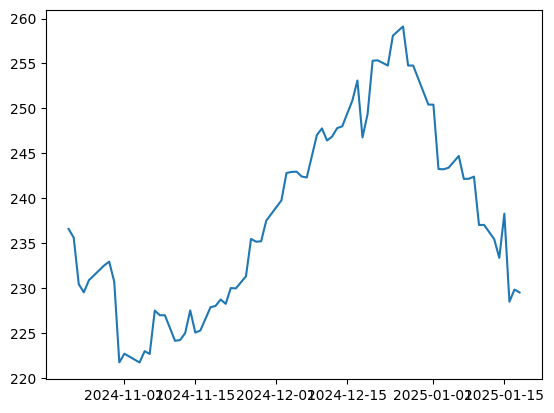

In [7]:
data['time'] = pd.to_datetime(data['time']).dt.date
plt.plot(data['time'], data['close_price'])

In [8]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('time', inplace=True)

    for i in range(1, n_steps+1):
        df[f'close_price(t-{i})'] = df['close_price'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,close_price,close_price(t-1),close_price(t-2),close_price(t-3),close_price(t-4),close_price(t-5),close_price(t-6),close_price(t-7)
time,,,,,,,,
2024-10-30,230.7000,232.9300,232.5000,230.8600,229.5100,230.4178,235.6000,236.5700
2024-10-31,221.7100,230.7000,232.9300,232.5000,230.8600,229.5100,230.4178,235.6000
2024-11-01,222.6800,221.7100,230.7000,232.9300,232.5000,230.8600,229.5100,230.4178
2024-11-04,221.7000,222.6800,221.7100,230.7000,232.9300,232.5000,230.8600,229.5100
2024-11-05,222.9600,221.7000,222.6800,221.7100,230.7000,232.9300,232.5000,230.8600
...,...,...,...,...,...,...,...,...
2025-01-14,233.3500,235.4300,237.0200,237.0100,242.4000,242.1600,242.1500,244.7006
2025-01-15,238.2735,233.3500,235.4300,237.0200,237.0100,242.4000,242.1600,242.1500
2025-01-16,228.4700,238.2735,233.3500,235.4300,237.0200,237.0100,242.4000,242.1600


In [9]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[Decimal('230.7000'), Decimal('232.9300'), Decimal('232.5000'),
        Decimal('230.8600'), Decimal('229.5100'), Decimal('230.4178'),
        Decimal('235.6000'), Decimal('236.5700')],
       [Decimal('221.7100'), Decimal('230.7000'), Decimal('232.9300'),
        Decimal('232.5000'), Decimal('230.8600'), Decimal('229.5100'),
        Decimal('230.4178'), Decimal('235.6000')],
       [Decimal('222.6800'), Decimal('221.7100'), Decimal('230.7000'),
        Decimal('232.9300'), Decimal('232.5000'), Decimal('230.8600'),
        Decimal('229.5100'), Decimal('230.4178')],
       [Decimal('221.7000'), Decimal('222.6800'), Decimal('221.7100'),
        Decimal('230.7000'), Decimal('232.9300'), Decimal('232.5000'),
        Decimal('230.8600'), Decimal('229.5100')],
       [Decimal('222.9600'), Decimal('221.7000'), Decimal('222.6800'),
        Decimal('221.7100'), Decimal('230.7000'), Decimal('232.9300'),
        Decimal('232.5000'), Decimal('230.8600')],
       [Decimal('222.6500'), Decima

In [10]:
shifted_df_as_np.shape

(67, 8)

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.51897381, -0.39978621, -0.42276857, -0.51042223, -0.58257616,
        -0.53405665, -0.25708177, -0.20523784],
       [-0.99946553, -0.51897381, -0.39978621, -0.42276857, -0.51042223,
        -0.58257616, -0.53405665, -0.25708177],
       [-0.94762159, -0.99946553, -0.51897381, -0.39978621, -0.42276857,
        -0.51042223, -0.58257616, -0.53405665],
       [-1.        , -0.94762159, -0.99946553, -0.51897381, -0.39978621,
        -0.42276857, -0.51042223, -0.58257616],
       [-0.93265633, -1.        , -0.94762159, -0.99946553, -0.51897381,
        -0.39978621, -0.42276857, -0.51042223],
       [-0.94922501, -0.93265633, -1.        , -0.94762159, -0.99946553,
        -0.51897381, -0.39978621, -0.42276857],
       [-0.69106895, -0.94922501, -0.93265633, -1.        , -0.94762159,
        -0.99946553, -0.51897381, -0.39978621],
       [-0.71886692, -0.69106895, -0.94922501, -0.93265633, -1.        ,
        -0.94762159, -0.99946553, -0.51897381],
       [-0.71886692, -0.71886692

In [12]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((67, 7), (67,))

In [13]:
X = dc(np.flip(X, axis=1))
X

array([[-0.20523784, -0.25708177, -0.53405665, -0.58257616, -0.51042223,
        -0.42276857, -0.39978621],
       [-0.25708177, -0.53405665, -0.58257616, -0.51042223, -0.42276857,
        -0.39978621, -0.51897381],
       [-0.53405665, -0.58257616, -0.51042223, -0.42276857, -0.39978621,
        -0.51897381, -0.99946553],
       [-0.58257616, -0.51042223, -0.42276857, -0.39978621, -0.51897381,
        -0.99946553, -0.94762159],
       [-0.51042223, -0.42276857, -0.39978621, -0.51897381, -0.99946553,
        -0.94762159, -1.        ],
       [-0.42276857, -0.39978621, -0.51897381, -0.99946553, -0.94762159,
        -1.        , -0.93265633],
       [-0.39978621, -0.51897381, -0.99946553, -0.94762159, -1.        ,
        -0.93265633, -0.94922501],
       [-0.51897381, -0.99946553, -0.94762159, -1.        , -0.93265633,
        -0.94922501, -0.69106895],
       [-0.99946553, -0.94762159, -1.        , -0.93265633, -0.94922501,
        -0.69106895, -0.71886692],
       [-0.94762159, -1.    

In [14]:
split_index = int(len(X) * 0.95)

split_index

63

In [15]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((63, 7), (4, 7), (63,), (4,))

In [16]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((63, 7, 1), (4, 7, 1), (63, 1), (4, 1))

In [17]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([63, 7, 1]),
 torch.Size([4, 7, 1]),
 torch.Size([63, 1]),
 torch.Size([4, 1]))

In [18]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [19]:
train_dataset

In [20]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [22]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [23]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99: 
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [24]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print()

In [55]:
learning_rate = 0.001
num_epochs = 150
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.063

Epoch: 2

Val Loss: 0.063

Epoch: 3

Val Loss: 0.061

Epoch: 4

Val Loss: 0.062

Epoch: 5

Val Loss: 0.063

Epoch: 6

Val Loss: 0.062

Epoch: 7

Val Loss: 0.063

Epoch: 8

Val Loss: 0.063

Epoch: 9

Val Loss: 0.063

Epoch: 10

Val Loss: 0.063

Epoch: 11

Val Loss: 0.062

Epoch: 12

Val Loss: 0.062

Epoch: 13

Val Loss: 0.062

Epoch: 14

Val Loss: 0.062

Epoch: 15

Val Loss: 0.062

Epoch: 16

Val Loss: 0.062

Epoch: 17

Val Loss: 0.061

Epoch: 18

Val Loss: 0.061

Epoch: 19

Val Loss: 0.061

Epoch: 20

Val Loss: 0.062

Epoch: 21

Val Loss: 0.062

Epoch: 22

Val Loss: 0.062

Epoch: 23

Val Loss: 0.062

Epoch: 24

Val Loss: 0.062

Epoch: 25

Val Loss: 0.061

Epoch: 26

Val Loss: 0.061

Epoch: 27

Val Loss: 0.061

Epoch: 28

Val Loss: 0.062

Epoch: 29

Val Loss: 0.061

Epoch: 30

Val Loss: 0.061

Epoch: 31

Val Loss: 0.061

Epoch: 32

Val Loss: 0.061

Epoch: 33

Val Loss: 0.062

Epoch: 34

Val Loss: 0.062

Epoch: 35

Val Loss: 0.062

Epoch: 36

Val Loss: 0.061

E

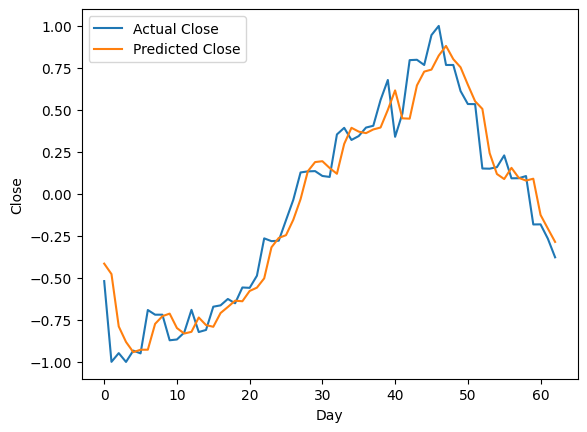

In [56]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [57]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([232.64731236, 231.48568356, 225.65086501, 223.92413391,
       222.78997701, 223.05797365, 223.06146201, 225.93846581,
       226.79235771, 227.08071907, 225.47141325, 224.86216452,
       225.05022565, 226.64732557, 225.80168728, 225.61316   ,
       227.14603985, 227.81689685, 228.51918249, 228.45641888,
       229.602814  , 229.97230972, 231.00884621, 234.46608339,
       235.50746432, 235.81609561, 237.53004426, 239.82715258,
       242.93384329, 243.95789481, 244.05359399, 243.29548436,
       242.65276574, 245.98009391, 247.77354816, 247.3477676 ,
       247.18002658, 247.59085228, 247.80509168, 249.77111131,
       251.93864421, 248.82938826, 248.79152377, 252.49303834,
       254.03122432, 254.25753356, 255.81415385, 256.89198073,
       255.41779735, 254.51261504, 252.57707668, 250.72796209,
       249.87721729, 244.95231009, 242.62625277, 242.06720322,
       243.31283719, 242.20185491, 241.89683368, 242.10351869,
       238.06933854, 236.55439673, 235.06470033])

In [58]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([230.69999969, 221.71000002, 222.68000016, 221.7       ,
       222.95999973, 222.65000009, 227.4801    , 226.95999947,
       226.95999947, 224.11000031, 224.20000053, 224.96989982,
       227.49999968, 225.03000033, 225.25999978, 227.85000053,
       227.99999978, 228.7100004 , 228.2300996 , 229.98989982,
       229.95000009, 231.30000004, 235.46169974, 235.14999997,
       235.20000009, 237.48970012, 239.74999999, 242.80070005,
       242.92      , 242.95000007, 242.41000001, 242.30250002,
       247.03449985, 247.77000014, 246.42000019, 246.85519976,
       247.80000022, 248.00000015, 250.86999991, 253.09999979,
       246.76999993, 249.35009991, 255.30999961, 255.34999971,
       254.76849946, 258.09999974, 259.12      , 254.77000052,
       254.77000052, 251.8679002 , 250.42190023, 250.4099999 ,
       243.23999995, 243.2199999 , 243.39079991, 244.70059987,
       242.14999993, 242.15999996, 242.39999998, 237.01000006,
       237.02000008, 235.4300001 , 233.35000003])

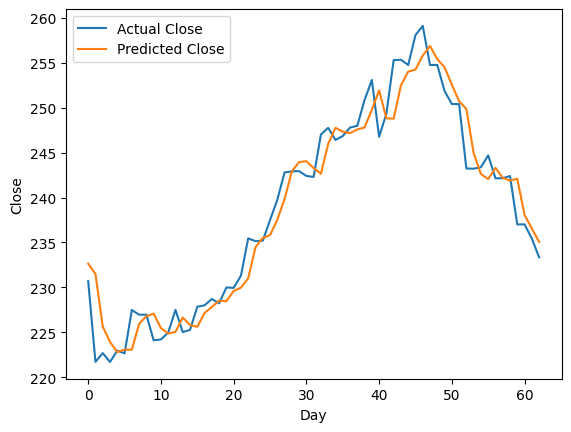

In [59]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [60]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([233.31240375, 236.64835146, 231.1127374 , 229.97194728])

In [61]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([238.27349999, 228.46999982, 229.82260042, 229.49899977])

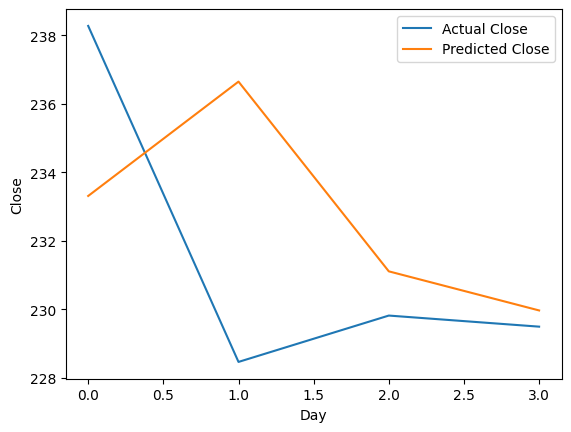

In [62]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

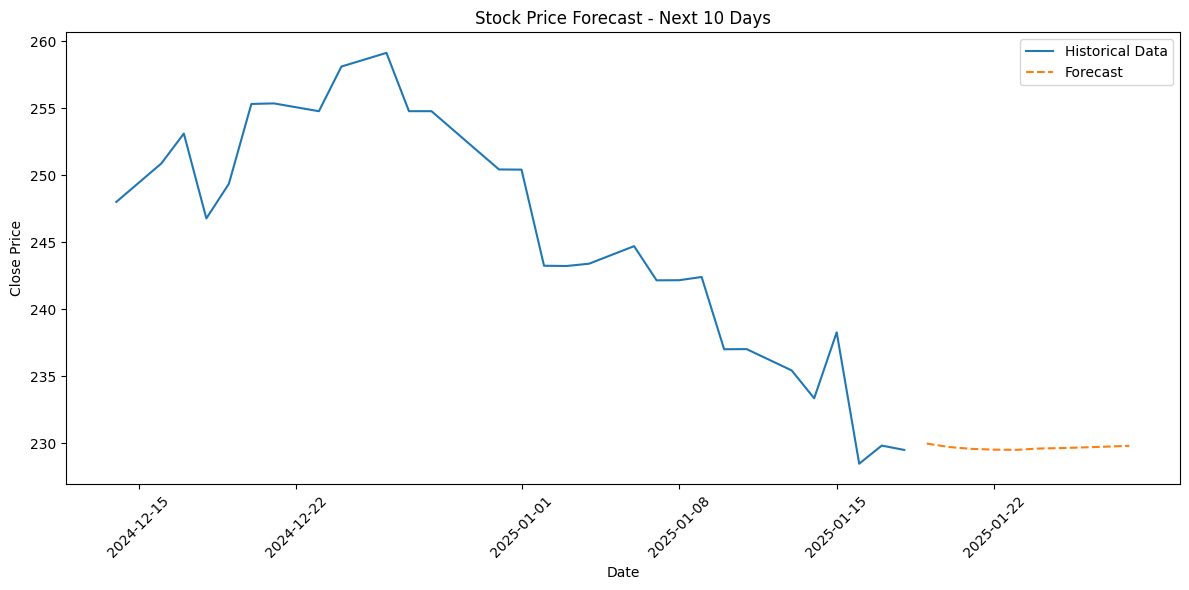


Forecasted values for next 10 days:
         Date  Forecasted_Close
0  2025-01-19        229.971947
1  2025-01-20        229.713150
2  2025-01-21        229.576177
3  2025-01-22        229.519246
4  2025-01-23        229.506195
5  2025-01-24        229.604003
6  2025-01-25        229.638628
7  2025-01-26        229.687897
8  2025-01-27        229.744970
9  2025-01-28        229.804308


In [63]:
last_sequence = X_test[-1:].to(device)
next_10_days_pred = []

for _ in range(10):
    with torch.no_grad():
        next_day = model(last_sequence).cpu().numpy()[0][0]
    next_10_days_pred.append(next_day)

    new_sequence = last_sequence.cpu().numpy()[0][1:]
    new_sequence = np.append(new_sequence, next_day)
    last_sequence = torch.tensor(new_sequence.reshape(1, lookback, 1)).float().to(device)

dummies = np.zeros((len(next_10_days_pred), lookback+1))
dummies[:, 0] = next_10_days_pred
dummies = scaler.inverse_transform(dummies)
next_10_days_pred = dc(dummies[:, 0])

last_date = data['time'].iloc[-1]
forecast_dates = pd.date_range(start=last_date, periods=11)[1:].date

plt.figure(figsize=(12, 6))
plt.plot(data['time'][-30:], data['close_price'][-30:], label='Historical Data')
plt.plot(forecast_dates, next_10_days_pred, label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Forecast - Next 10 Days')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted_Close': next_10_days_pred
})
print("\nForecasted values for next 10 days:")
print(forecast_df)